We will work on this notebook to implement the algorithm.
Please check regularly for updates.

Main tasks:
1. Write the code for the algorithm
2. Find better $\alpha$ and $\beta$ values for the model.
3. Find stopping criteria for the model.
4. Apply the new hyperparameters to the algorithm, and evaluate the results on a lexical similarity task, then on a sentiment analysis task.

In [5]:
# Importing the libraries:
import numpy as np
import gensim.models.word2vec as w2v
import gensim.downloader as api
import math
import re
from copy import deepcopy
import sys
import gzip
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
# Define a read vectors function to read the vectors from the file
def read_vectors_file(filename):
    word_vectors = {}
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                word = parts[0]
                vector = [float(x) for x in parts[1:]]
                word_vectors[word] = np.array(vector) # Convert to numpy array for later use in the code
    return word_vectors

# Read the vectors from the file as a dictionary
vectors = read_vectors_file('vectors_datatxt_250_sg_w10_i5_c500_gensim_clean.gz')

In [8]:
print(f"The vocabulary size is {len(vectors)}")
print(f"The vector size is {len(vectors['the'])}")
print(vectors['the'])

The vocabulary size is 125777
The vector size is 250
[ 2.16749e-01 -1.84148e-01  1.16644e-01 -9.11750e-02 -9.30600e-02
 -2.44480e-02 -9.81810e-02  1.36277e-01  3.13000e-03  1.32696e-01
 -2.18930e-02  5.00290e-02  9.29950e-02  1.01006e-01 -2.72782e-01
  6.58980e-02  7.98310e-02  1.20830e-01  1.83800e-03  1.09131e-01
 -1.97052e-01 -1.57743e-01 -8.70130e-02 -2.88130e-02 -3.17270e-02
 -5.69130e-02 -1.90135e-01 -8.91000e-03  9.18300e-03 -1.76240e-01
 -2.60480e-02  5.36160e-02 -1.87425e-01 -4.40870e-02  5.22380e-02
  1.50861e-01  1.00894e-01 -1.04502e-01  8.82450e-02  1.24603e-01
  6.53740e-02 -2.40738e-01  1.36660e-01 -1.86156e-01  9.86000e-04
 -1.45817e-01 -5.92010e-02 -1.90453e-01  3.65760e-02 -6.44750e-02
  2.49990e-02 -1.95380e-02  1.58472e-01 -1.87950e-01  4.67110e-02
  1.47299e-01  4.59230e-02  9.47430e-02  2.03657e-01  8.17700e-02
  3.84720e-02  3.61040e-02 -3.33310e-02  6.79180e-02  1.37791e-01
  3.22300e-02 -2.24442e-01  1.70670e-02  4.42260e-02  5.49500e-02
  1.08627e-01  5.26030e

In [9]:
# Toy corpus of 10 words:
toy_corpus = ['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect']

# Vectorize the toy corpus:
vec_toy_corpus = [vectors[word] for word in toy_corpus]


In [10]:
# These are the way when I used the gensim model. It's just too large or my laptop to run.
# Load the word2vec model:
#wv = api.load('word2vec-google-news-300')
#wv = w2v.Word2Vec(vector_size=250, min_count=500, window=8, sample=1e-3, workers=8, sg=1, hs=0, negative=10, epochs=5)

# Vectorize the toy corpus:
#vec_toy_corpus = [wv.wv[word] for word in toy_corpus]
#vec_toy_corpus = [wv[word] for word in toy_corpus]


In [11]:
# Compare vectors using cosine similarity:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute the cosine similarity matrix:
similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        similarity_matrix[i][j] = cosine_similarity(vec_toy_corpus[i], vec_toy_corpus[j])

# Print the cosine similarity matrix:
#for i in range(len(vec_toy_corpus)):
#    for j in range(len(vec_toy_corpus)):
#        print(f'Similarity between {toy_corpus[i]} and {toy_corpus[j]} is {similarity_matrix[i][j]:.4f}')

Similarity between frog and frog is 1.0000
Similarity between frog and toad is 0.8230
Similarity between frog and berger is 0.1562
Similarity between frog and cat is 0.4293
Similarity between frog and cheetah is 0.4210
Similarity between frog and dog is 0.4787
Similarity between frog and feline is 0.4080
Similarity between frog and true is 0.2558
Similarity between frog and false is 0.2080
Similarity between frog and incorrect is 0.1676
Similarity between toad and frog is 0.8230
Similarity between toad and toad is 1.0000
Similarity between toad and berger is 0.1870
Similarity between toad and cat is 0.4009
Similarity between toad and cheetah is 0.4266
Similarity between toad and dog is 0.4755
Similarity between toad and feline is 0.4256
Similarity between toad and true is 0.2198
Similarity between toad and false is 0.1945
Similarity between toad and incorrect is 0.1342
Similarity between berger and frog is 0.1562
Similarity between berger and toad is 0.1870
Similarity between berger an

# 1. Implementing the algorithm and finding the best hyperparameters.

In [12]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters, alpha = 1, beta = 2): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha
      newVec = alpha * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += beta * newWordVecs[ppWord] 
      newWordVecs[word] = newVec/(alpha + beta) 
  return newWordVecs

In [13]:
# Transform the toy corpus into a wordVecs dictionary:
toy_wordVecs = {}
for i in range(len(vec_toy_corpus)):
    toy_wordVecs[toy_corpus[i]] = vec_toy_corpus[i]
print(toy_wordVecs.keys())

dict_keys(['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect'])


In [14]:
# Read the lexicon. We can use NLTK WordNet.
lexicon = {}
# The idea is to create a dictionary where the keys are the words in the corpus
# and the values are the words that are related to the key word from the WordNet.
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in lexicon:
            lexicon[word] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word != word:
                    lexicon[word].append(related_word)


In [15]:
# We can take a peek at the lexicon too:
print(lexicon['cat'])

['domestic_cat', 'house_cat', 'Felis_domesticus', 'Felis_catus', 'wildcat', 'feline', 'felid', 'cheetah', 'chetah', 'Acinonyx_jubatus', 'jaguar', 'panther', 'Panthera_onca', 'Felis_onca', 'leopard', 'Panthera_pardus', 'liger', 'lion', 'king_of_beasts', 'Panthera_leo', 'saber-toothed_tiger', 'sabertooth', 'snow_leopard', 'ounce', 'Panthera_uncia', 'tiger', 'Panthera_tigris', 'tiglon', 'tigon', 'feline', 'felid', 'Felidae', 'family_Felidae', 'tracked_vehicle', 'whip', 'stimulant', 'stimulant_drug', 'excitant', 'gossip', 'gossiper', 'gossipmonger', 'rumormonger', 'rumourmonger', 'newsmonger', 'woman', 'adult_female', 'sod', 'man', 'adult_male', 'excrete', 'egest', 'eliminate', 'pass', 'flog', 'welt', 'whip', 'lather', 'lash', 'slash', 'strap', 'trounce']


In [16]:
# Retrofit the word vectors using basic hyperparameters:
newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = 2)

# Similarity matrix after retrofitting:
retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
        
# Print the cosine similarity matrix:
retrofit_effect_matrix = retro_similarity_matrix - similarity_matrix
#print('Retrofitting effect matrix: ')
#print(retrofit_effect_matrix)


print(f'Similarity is changed by {retrofit_effect_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {retrofit_effect_matrix[2][5]:.4f} between {toy_corpus[2]} and {toy_corpus[5]}')
print(f'Similarity is changed by {retrofit_effect_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

print('There has been some improvements in the toy corpus, so the retrofit algorithm works! We can move on to find the better hyperparameters.')

Retrofitting effect matrix: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.71678401e-02
   9.63492001e-02  0.00000000e+00  1.05254433e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12722981e-01
   8.89300489e-02  0.00000000e+00  8.71421761e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.28742965e-02
   7.60448189e-03  0.00000000e+00  6.58482455e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.71678401e-02  1.12722981e-01  3.28742965e-02  2.22044605e-16
   5.49414177e-01  1.49499263e-02  4.30844945e-01 -3.38107707e-02
  -3.73012166e-02 -2.95947883e-02]
 [ 9.63492001e-02  8.89300489e-02  7.60448189e-03  5.49414177e-01
   0.00000000e+00  2.65720479e-01  5.38204509e-01  1.17406178e-01
   6.48046469e-02  5.35970178e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.49499263e-02
   2.65720479e-01  0.00000000e+00  1.02295602e-01  0.00000000e+00
   0

Alpha is 0.1
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Alpha is 0.4
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Alpha is 0.7
Similarity is changed by 0.4329 between cat and feline
Similarity is changed by 0.5520 between cat and cheetah
Alpha is 1.0
Similarity is changed by 0.4308 between cat and feline
Similarity is changed by 0.5494 between cat and cheetah
Alpha is 1.3
Similarity is changed by 0.4246 between cat and feline
Similarity is changed by 0.5413 between cat and cheetah
Alpha is 1.6
Similarity is changed by 0.4150 between cat and feline
Similarity is changed by 0.5284 between cat and cheetah
Alpha is 1.9
Similarity is changed by 0.4038 between cat and feline
Similarity is changed by 0.5133 between cat and cheetah
Alpha is 2.2
Similarity is changed by 0.3921 between cat and feline
Similarity is changed by 0.4974 between cat and cheetah
Alpha is

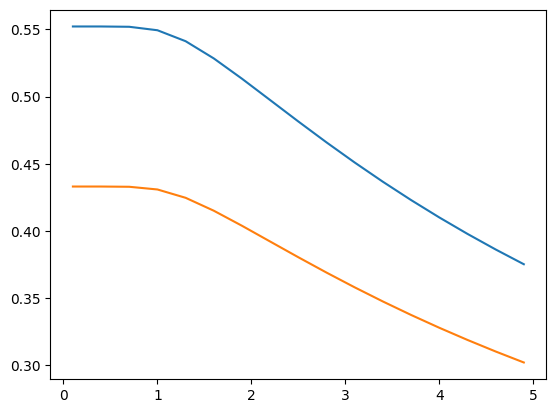

The best alpha is 1 for feline and 1 for cheetah


In [17]:
# Test different hyperparameters:
# Test alpha:
improvement_cheetah = []
improvement_feline = []
for alpha in np.arange(0.1, 5.1, 0.3):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = alpha, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    print(f'Alpha is {alpha:.1f}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])

# Plot the results:
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_cheetah, label = 'cheetah')
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_feline, label = 'feline')
plt.show()
print(f"The best alpha is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Beta is 1
Similarity is changed by 0.3999 between cat and feline
Similarity is changed by 0.5081 between cat and cheetah
Beta is 2
Similarity is changed by 0.4308 between cat and feline
Similarity is changed by 0.5494 between cat and cheetah
Beta is 3
Similarity is changed by 0.4329 between cat and feline
Similarity is changed by 0.5521 between cat and cheetah
Beta is 4
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Beta is 5
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Beta is 6
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Beta is 7
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Beta is 8
Similarity is changed by 0.4330 between cat and feline
Similarity is changed by 0.5522 between cat and cheetah
Beta is 9
Similarity is changed 

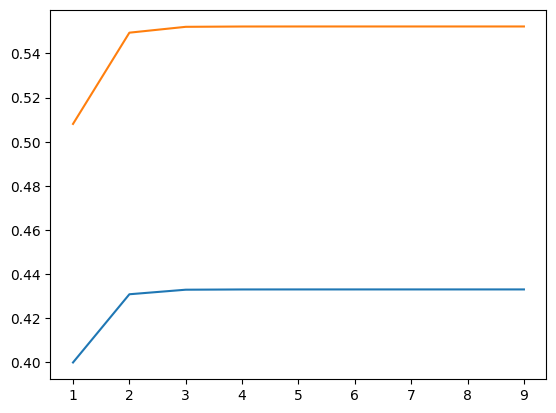

The best beta is 9 for feline and 9 for cheetah


In [18]:
# Test beta:
improvement_feline = []
improvement_cheetah = []
for beta in range(1, 10):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = beta)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Beta is {beta}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 10), improvement_feline, label = 'feline')
plt.plot(range(1, 10), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best beta is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Number of iterations is 1
Similarity is changed by 0.4219 between cat and feline
Similarity is changed by 0.5394 between cat and cheetah
Number of iterations is 2
Similarity is changed by 0.4255 between cat and feline
Similarity is changed by 0.5430 between cat and cheetah
Number of iterations is 3
Similarity is changed by 0.4274 between cat and feline
Similarity is changed by 0.5452 between cat and cheetah
Number of iterations is 4
Similarity is changed by 0.4285 between cat and feline
Similarity is changed by 0.5465 between cat and cheetah
Number of iterations is 5
Similarity is changed by 0.4293 between cat and feline
Similarity is changed by 0.5475 between cat and cheetah
Number of iterations is 6
Similarity is changed by 0.4298 between cat and feline
Similarity is changed by 0.5481 between cat and cheetah
Number of iterations is 7
Similarity is changed by 0.4302 between cat and feline
Similarity is changed by 0.5486 between cat and cheetah
Number of iterations is 8
Similarity is c

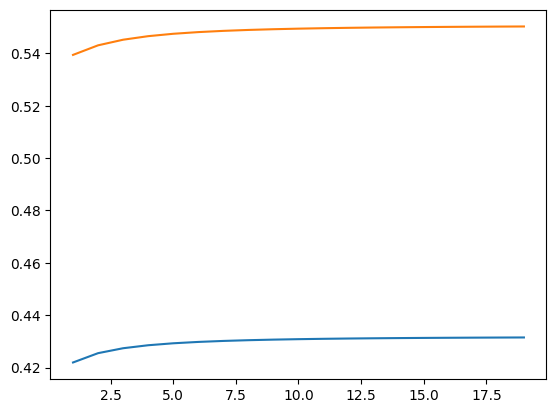

The best number of Iteration is 19 for feline and 19 for cheetah


In [19]:
# Test number of iterations:
improvement_feline = []
improvement_cheetah = []
for iter in range(1, 20):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = iter, alpha = 1, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Number of iterations is {iter}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 20), improvement_feline, label = 'feline')
plt.plot(range(1, 20), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best number of Iteration is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

From these results, we can see that the performance of the retrofitting algorithm works best with this set of hyperparameters: alpha = 1, beta = 2, and nb_iter = 7, because the performance does not increase significantly when these hyperparameters are increased.

# 2. Implement the algorithm in matrix form.

In order to implement the retrofitting algorithm in the matrix form, we will assume that the input is the whole word embeddings matrix E(w), and the output is the whole word embeddings matrix E'(w). The retrofitting algorithm will be applied to the whole word embeddings matrix E(w) to get the whole word embeddings matrix E'(w).

To do this, we will have to change the way the lexicon works. At the moment, it is a dictionary with words as keys and their neighbors as values, but to have better performance on a larger vocabulary, it should have indices instead of words. This way, we can use the indices to access the word embeddings matrix E(w) and E'(w).

In [20]:
# Word ids and indices:
def build_word_index_mappings(word_vectors):
    word_to_index = {}
    index_to_word = []
    for i, word in enumerate(word_vectors.keys()):
        word_to_index[word] = i
        index_to_word.append(word)
    return word_to_index, index_to_word

word_ids, word_indices = build_word_index_mappings(vectors)


In [21]:
# Take a look at the lexicon:
print(word_ids['dog'])
print(lexicon['dog'])

2122
['basenji', 'corgi', 'Welsh_corgi', 'cur', 'mongrel', 'mutt', 'dalmatian', 'coach_dog', 'carriage_dog', 'Great_Pyrenees', 'griffon', 'Brussels_griffon', 'Belgian_griffon', 'hunting_dog', 'lapdog', 'Leonberg', 'Mexican_hairless', 'Newfoundland', 'Newfoundland_dog', 'pooch', 'doggie', 'doggy', 'barker', 'bow-wow', 'poodle', 'poodle_dog', 'pug', 'pug-dog', 'puppy', 'spitz', 'toy_dog', 'toy', 'working_dog', 'canine', 'canid', 'domestic_animal', 'domesticated_animal', 'flag', 'Canis', 'genus_Canis', 'pack', 'support', 'catch', 'stop', 'ratchet', 'rachet', 'ratch', 'Vienna_sausage', 'sausage', 'hotdog', 'hot_dog', 'red_hot', 'perisher', 'villain', 'scoundrel', 'chap', 'fellow', 'feller', 'fella', 'lad', 'gent', 'blighter', 'cuss', 'bloke', 'unpleasant_woman', 'disagreeable_woman', 'hound', 'hunt', 'trace', 'quest', 'run_down', 'tree', 'pursue', 'follow']


In [22]:
# Create a new dictionary to store the lexicon with word IDs
# This dictionary will have as keys the word IDs and as values the list of IDs of the words in the lexicon that are related to the key. The words not present in the vocabulary are ignored.
# This is done to ensure that the IDs of the words in the lexicon are the same as the IDs of the words in the vocabulary.
lexicon_with_ids = {}

# Using the same method as above, but this time we are using the word IDs instead of the words themselves
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in word_ids:
            continue
        if word not in lexicon_with_ids:
            lexicon_with_ids[word_ids[word]] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word in word_ids:
                    if related_word != word:
                        lexicon_with_ids[word_ids[word]].append(word_ids[related_word])

In [23]:
# Test new lexicon:
print(lexicon_with_ids.keys()) # List of word IDs
print(lexicon_with_ids.get(2122)) # dog

dict_keys([633, 2202, 13527, 23030, 42473, 21305, 30812, 4036, 5342, 37289, 117, 31095, 901, 9794, 46399, 56225, 26116, 5371, 1523, 16085, 104807, 8311, 294, 3385, 9661, 23456, 65157, 76944, 105562, 25529, 72004, 32080, 46598, 9119, 36436, 28236, 18482, 121117, 81650, 69621, 43906, 19990, 33157, 77219, 6899, 41732, 13421, 4748, 10829, 4030, 4970, 549, 16586, 11016, 117523, 42046, 13807, 32902, 21368, 2022, 36915, 1706, 31478, 16909, 91117, 86426, 62738, 5151, 207, 22680, 14961, 2401, 39703, 26317, 55350, 14378, 2256, 4541, 8471, 36101, 12363, 4356, 87096, 95601, 7678, 25527, 4920, 45411, 45484, 13718, 20987, 24841, 4106, 103515, 114984, 64779, 28195, 69307, 65085, 48508, 4009, 585, 9239, 8973, 1739, 1105, 251, 10653, 489, 706, 15054, 6248, 1277, 37211, 1220, 17018, 68550, 49, 8393, 21243, 3883, 26788, 1730, 4466, 2006, 2601, 5431, 360, 2509, 31428, 78688, 87898, 36726, 1788, 33546, 60334, 100527, 120628, 112100, 31370, 90487, 29877, 44500, 19348, 42595, 1186, 63, 32117, 2955, 55002, 22

In [24]:
# Create the embedding matrix:
embedding_matrix = np.zeros((len(word_indices), 250))

# Fill the embedding matrix with the word vectors from the word2vec model
for i in range(len(word_indices)):
    embedding_matrix[i] = vectors[word_indices[i]]   

In [25]:
# Create a neighbor matrix from the new lexicon:
# The value for each word is the sum of the embeddings of the words in the lexicon that are related to the word
neighbor_matrix = np.zeros((len(word_indices), 250)) # It's a matrix of size (vocab_size, 250)
# Fill the neighbor matrix:
# For each word in the lexicon, we sum the embeddings of the words in the lexicon that are related to the word
for key in lexicon_with_ids.keys():
    neighbor_matrix[key] = np.sum(embedding_matrix[lexicon_with_ids[key]], axis = 0)

In [26]:
print(lexicon_with_ids[word_ids['dog']]) # dog has 7 related words
print(embedding_matrix[lexicon_with_ids[word_ids['dog']]].shape) 
print(neighbor_matrix[word_ids['dog']].shape) # dog 

[19729, 3446, 7013, 6109, 1947, 4721, 1550]
(7, 250)
(250,)


In [27]:
# Define the retrofitting algorithm, using the previously found hyperparameters:
def retrofit_matrix(embedding_matrix, neighbor_matrix, alpha = 1, beta = 2, nb_iters = 7):
    new_embedding_matrix = embedding_matrix
    for i in range(nb_iters):
        new_embedding_matrix = (alpha * new_embedding_matrix + beta * neighbor_matrix) / (alpha + beta)
    return new_embedding_matrix

# Run the algorithm on the embedding matrix:
retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix)

# 3. Evaluations.
We will evaluate the new retrofitted word embeddings on a lexical similarity task, and a sentiment analysis task.
## 3.1. Lexical similarity task.
We will use the WordSim353 dataset to evaluate the performance of the retrofitting algorithm on a lexical similarity task. The WordSim353 dataset contains 353 pairs of words, and each pair is assigned a similarity score by human annotators. The similarity score ranges from 0 to 10, with 0 being not similar at all, and 10 being very similar. We will use the cosine similarity between the word embeddings of each pair of words to calculate the similarity score, and then compare it with the human similarity score to see how well the retrofitting algorithm performs.

In [29]:
# Read the WordSim353 dataset as a pandas dataframe:
def read_ws353():
    with open('ws353.txt', 'r') as f:
        data = f.read()
    lines = data.split('\n')
    lines = lines[0:-1]
    word1 = []
    word2 = []
    human_scores = []
    for line in lines:
        tokens = line.split('\t')
        word1.append(tokens[0])
        word2.append(tokens[1])
        human_scores.append(float(tokens[2]))
    df = pd.DataFrame({'word1': word1, 'word2': word2, 'score': human_scores})

    return df

ws353_data = read_ws353()

In [ ]:
print(ws353_data)

            word1     word2  score
0            love       sex   6.77
1           tiger       cat   7.35
2           tiger     tiger  10.00
3            book     paper   7.46
4        computer  keyboard   7.62
..            ...       ...    ...
348        shower     flood   6.03
349       weather  forecast   8.34
350      disaster      area   6.25
351      governor    office   6.34
352  architecture   century   3.78

[353 rows x 3 columns]


In [30]:
# Create a function to compute the cosine similarity between two words:
def cosine_similarity(word1, word2, embedding_matrix):
    if word1 not in word_ids or word2 not in word_ids:
        return None
    word1_embedding = embedding_matrix[word_ids[word1]]
    word2_embedding = embedding_matrix[word_ids[word2]]
    return np.dot(word1_embedding, word2_embedding) / (np.linalg.norm(word1_embedding) * np.linalg.norm(word2_embedding))

# Calculate the score for each pair of words in the dataset:
ws353_data['original_score'] = ws353_data.apply(lambda row: cosine_similarity(row['word1'], row['word2'], embedding_matrix), axis = 1)
ws353_data['retrofitted_score'] = ws353_data.apply(lambda row: cosine_similarity(row['word1'], row['word2'], retrofitted_matrix), axis = 1)

# Calculate the Spearman correlation between the human scores and the model scores:
print(ws353_data[['score', 'original_score']].corr(method = 'spearman'))
print(ws353_data[['score', 'retrofitted_score']].corr(method = 'spearman'))

                   score  original_score
score           1.000000        0.690526
original_score  0.690526        1.000000
                      score  retrofitted_score
score              1.000000           0.158578
retrofitted_score  0.158578           1.000000


## 3.2. Sentiment analysis task.
We will use the Stanford Sentiment Treebank dataset to evaluate the performance of the retrofitting algorithm on a sentiment analysis task. The Stanford Sentiment Treebank dataset contains 11,855 sentences, and each sentence is assigned a sentiment score by human annotators. The sentiment score ranges from 0 to 4, with 0 being very negative, and 4 being very positive. We will use the cosine similarity between the word embeddings of each sentence to calculate the sentiment score, and then compare it with the human sentiment score to see how well the retrofitting algorithm performs. (it's just nonsense that Copilot generated, I will rewrite it later)